In [1]:
# Import libraries
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
from osgeo import gdal
import os
import sys

In [16]:
# load file
file = 'GlobSnow_SWE_L3B_monthly_201102_v2.0.nc'
f = xr.open_dataset(file)
f

<xarray.Dataset>
Dimensions:                       (x: 721, y: 721)
Coordinates:
  * x                             (x) float64 -9.024e+06 ... 9.024e+06
  * y                             (y) float64 -9.024e+06 ... 9.024e+06
Data variables:
    lambert_azimuthal_equal_area  |S1 ...
    lat                           (y, x) float32 ...
    lon                           (y, x) float32 ...
    SWE_avg                       (y, x) float32 ...
    SWE_max                       (y, x) float32 ...
Attributes:
    GDAL_AREA_OR_POINT:           Area
    Conventions:                  CF-1.5
    GDAL:                         GDAL 1.10.1, released 2013/08/26
    history:                      Sat Jan 04 16:26:21 2014: GDAL CreateCopy( ...
    title:                        GLOBSNOW FPS SWE
    sensor:                       SSM/I
    Data Date:                    2011-02
    Processing Date:              2014-01-04
    Coordinate System:            Equal-Area Scalable Earth Grid (EASE-Grid) ...
    Lati

In [15]:
f.lat.values


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [14]:
# Path of netCDF file
netcdf_name = "C:/Users/vicki/Documents/GlobSnow/GlobSnow_SWE_L3B_monthly_nc/GlobSnow_SWE_L3B_monthly_201102_v1.2.nc"

# Specify the layer name to read
layer_name = "SWE"

# Open netcdf file.nc with gdal
ds = gdal.Open("NETCDF:{0}:{1}".format(netcdf_name, layer_name))

# Read full data from netcdf
data = ds.ReadAsArray(0, 0, ds.RasterXSize, ds.RasterYSize)
data[data < 0] = 0

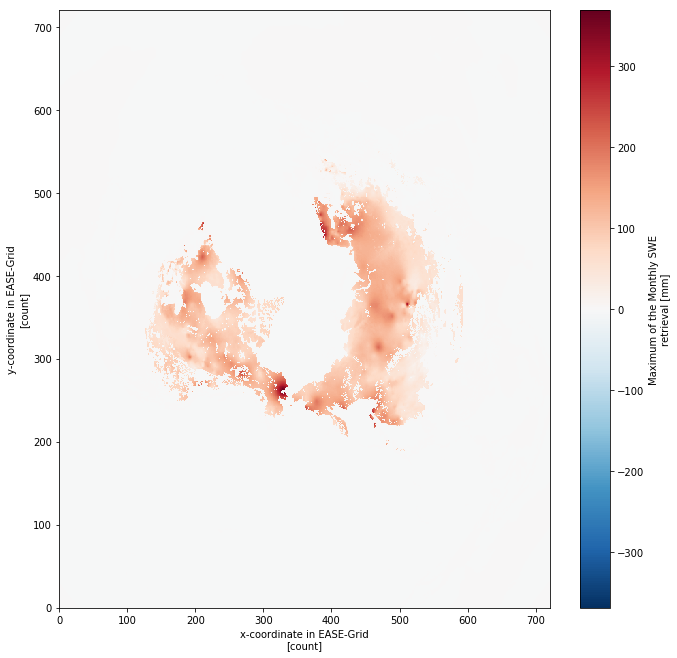

In [42]:
# plot
plt.figure(figsize=(11,11))
f.SWEV.plot()


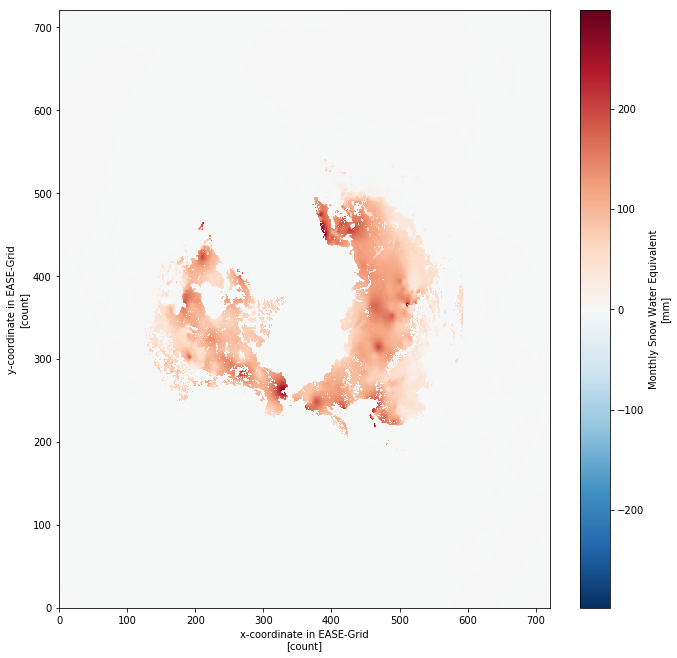

In [43]:
# plot
plt.figure(figsize=(11,11))
f.SWE.plot()


In [5]:
# trouble shooting with Steven, seems like in this projection the edges are 0's, but they need to be nans
# test to try to assign all those corner edges -- literally not on planet earth -- 0's 
# assign corner edges the value 0 
# where is nan, give it a 0
f['longitude'] = f.longitude.where(~np.isnan(f.longitude), 0)
f['SWE'] = f.SWE.where(~np.isnan(f.longitude), 0)
f['SWEV'] = f.SWEV.where(~np.isnan(f.longitude), 0)
f['latitude'] = f.latitude.where(f.latitude<90, 0)

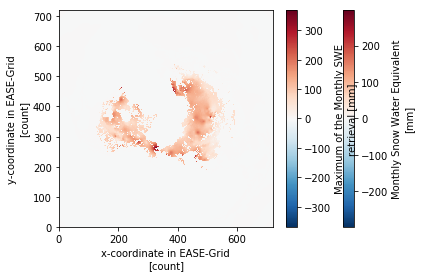

In [45]:
# plot SWE
f.SWE.plot()
f.SWEV.plot()

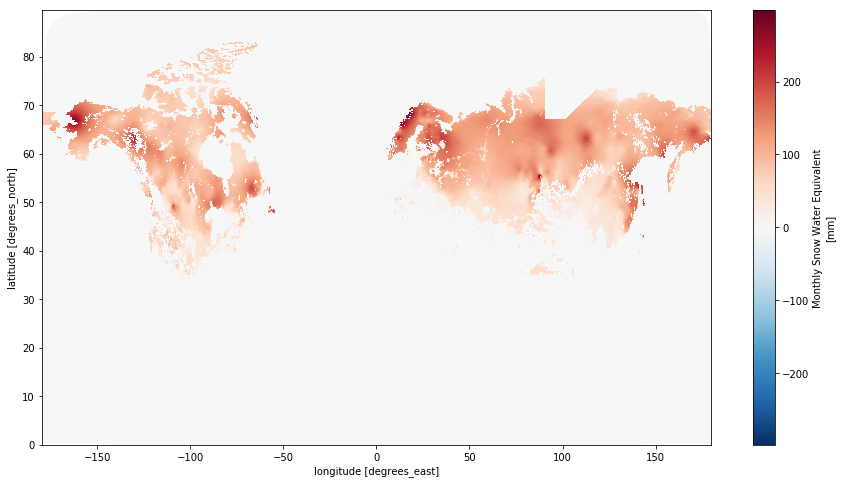

In [6]:
# plot
# note: where 0s occur at lat long, they're plotted at 0,0
plt.figure(figsize=(15,8))
f.SWE.plot(x='longitude',y='latitude')

In [7]:
# test to try to get rid of those values
SWE = f.SWE.values

In [8]:
print(SWE)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [10]:
# Check projection
f.projection

<xarray.DataArray 'projection' ()>
array(b'EASE-Grid', dtype='|S10')
Attributes:
    grid_id:                                    NL
    reference:                                  EASE-Grid projection definiti...
    NSIDC_mapx_grid_parameter_definition_file:  Nl.gpd
    grid_mapping_name:                          lambert_azimuthal_equal_area
    longitude_of_projection_origin:             0.0
    latitude_of_projection_origin:              90.0
    false_easting:                              0.0
    false_northing:                             0.0
    projection_x_coordinate_origin:             360.0
    projection_y_coordinate_origin:             360.0
    scale_factor_at_projection_origin:          25.06753

In [11]:
# Make a string given the metadata
# There's a bunch of stuff here to double check -- basically everything in the string
# Projection, lat long, see Steven's Github for example

def getProj4string(projection_info):
    '''make a proj4 string  and a pyproj map object from projection information'''
    
    lon0=projection_info.longitude_of_projection_origin # Center longitude 
    lat0=projection_info.latitude_of_projection_origin #  Center latitude (0.0)
    false_e=projection_info.false_easting
    false_n=projection_info.false_northing
    scale=projection_info.scale_factor_at_projection_origin
    
    # Make proj4 string
    proj_string = '"+proj=laea +ellps=WGS84 +lon_0={} +lat_0={} +k_0={} +x_0={} +y_0={}"'.format(
        lon0,lat0,scale,false_e,false_n,scale)
    
    return proj_string

In [12]:
# make a proj4 string and a pyproj geostationary map object from this file's projection information
# reproject 
proj_string = getProj4string(f.projection)
print(proj_string)

"+proj=laea +ellps=WGS84 +lon_0=0.0 +lat_0=90.0 +k_0=25.067529678344727 +x_0=0.0 +y_0=0.0"


In [13]:
#assign proj4 string to file
# check this website: https://spectraldifferences.wordpress.com/2014/12/01/assign-a-projection-to-an-image-from-a-wkt-file/

<xarray.DataArray 'projection' ()>
array(b'EASE-Grid', dtype='|S10')
Attributes:
    grid_id:                                    NL
    reference:                                  EASE-Grid projection definiti...
    NSIDC_mapx_grid_parameter_definition_file:  Nl.gpd
    grid_mapping_name:                          lambert_azimuthal_equal_area
    longitude_of_projection_origin:             0.0
    latitude_of_projection_origin:              90.0
    false_easting:                              0.0
    false_northing:                             0.0
    projection_x_coordinate_origin:             360.0
    projection_y_coordinate_origin:             360.0
    scale_factor_at_projection_origin:          25.06753